## finalizingReadPlotting_matplotlib.ipynb
### Marcus Viscardi     June 16, 2022

So I tried to just run what was in testingReadPlotting_matplotlib.py with tba-1 and tba-2 b/c josh wanted those for grants. But the script didn't work. I am fairly sure it is due to these genes being negative strand... I was also having a hard time deciphering what was happening in the other code because it was really hard-coded to plot the stuff for ubl-1 and my RNA society poster.

The new plan is to keep that code function and rewrite stuff here to be a little more reusable. Then one I have troubleshooted the hell out of all of this I'll drop it into a real script that I can package and give to folks. Potentially with the addition of the coverage plotting on top of this? Would be cool!

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', None)

import re

import seaborn as sea
import matplotlib.pyplot as plt
import sys

import warnings
sys.path.insert(0, '/data16/marcus/scripts/nanoporePipelineScripts')
from nanoporePipelineCommon import *

print("imports done")

imports done


In [2]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

def _make_rectangle_patch(genome_start, length, y_center, thickness, color='gray'):
    return Rectangle((genome_start, y_center-(thickness/2)), length, thickness,
                     facecolor=color,
                     edgecolor=color,
                     fill=True,
                     lw=0)


def _add_patches_from_cigars_and_gen_pos(axes, cigar, gen_start, y, strand, color='black', plot_introns=True,tail_length=None):
    # Parse the cigar string
    parsed_cigar = re.findall(rf'(\d+)([MDNSIX])', cigar)
    mdn_nums = [int(num) for num, char in parsed_cigar if char in "MDN"]
    gen_end = gen_start + sum(mdn_nums)
    genomic_read_length = gen_end - gen_start
    
    genome_loc = gen_start
    
    rectangle_patch_list = []
    first_n_length = 0
    for length, code in parsed_cigar:
        length = int(length)
        if code == 'S':
            pass
        elif code == 'M':
            rectangle_patch_list.append(_make_rectangle_patch(genome_loc, length, y, thickness=0.8))
            genome_loc += length
        elif code == 'D':
            if length < 50:
                rectangle_patch_list.append(_make_rectangle_patch(genome_loc, length, y, thickness=0.8))
            else:
                if plot_introns:
                    rectangle_patch_list.append(_make_rectangle_patch(genome_loc, length, y, thickness=0.001))
            genome_loc += length
        elif code == 'I':
            pass
        elif code == 'N':
            if plot_introns:
                rectangle_patch_list.append(_make_rectangle_patch(genome_loc, length, y, thickness=0.001))
            genome_loc += length
    axes.add_collection(PatchCollection(rectangle_patch_list, color=color))
    if isinstance(tail_length, float):
        if strand == "+":
            axes.add_patch(_make_rectangle_patch(genome_loc, tail_length, y, thickness=0.4, color='green'))
            genome_loc += tail_length
        else:
            axes.add_patch(_make_rectangle_patch(gen_start, -tail_length, y, thickness=0.4, color='green'))
    return genomic_read_length


def _row_apply_plot_cigar(row, axes, plot_introns=True):
    index = row.name
    cigar = row.cigar
    gen_start = row.original_chr_pos
    is_adapted = row.t5
    polya_length = row.polya_length
    strand = row.strand
    
    if is_adapted == '-':
        color='black'
    else:
        color='red'
    return _add_patches_from_cigars_and_gen_pos(axes, cigar, gen_start, index, strand,
                                               color=color,
                                               plot_introns=plot_introns,
                                               tail_length=polya_length)


def _get_gene_coordinates(
        gene_id=None, gene_name=None,
        parsed_gtf_path="/data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.gtf.parquet"
) -> (str, str, int, int):
    # First make sure we got something to look up:
    gene_id_bool = isinstance(gene_id, str)
    gene_name_bool = isinstance(gene_name, str)
    if not gene_id_bool and not gene_name_bool:
        raise NotImplementedError(f"Please pass a gene_id or a gene_name!")
    # Load the parsed gtf_file
    try:
        gtf_df = pd.read_parquet(parsed_gtf_path)[["gene_id",
                                                   "gene_name",
                                                   "feature",
                                                   "chr",
                                                   "start",
                                                   "end",
                                                   "strand"]].query("feature == 'gene'")
    except FileNotFoundError:
        raise FileNotFoundError(f"Please make sure there is a parsed gtf file at: {parsed_gtf_path}")

    # Get the gene of interest!
    try:
        if gene_id_bool:
            entry_of_interest = gtf_df.query(f"gene_id == '{gene_id}'").reset_index(drop=True).iloc[0].to_dict()
            gene_name = entry_of_interest["gene_name"]
        else:  # if gene_name_bool
            entry_of_interest = gtf_df.query(f"gene_name == '{gene_name}'").reset_index(drop=True).iloc[0].to_dict()
            gene_id = entry_of_interest["gene_id"]
    except IndexError:
        raise IndexError(f"Gene of interest (gene_id: {gene_id} / gene_name: {gene_name}) not found!")
    chromosome = entry_of_interest["chr"]
    start = entry_of_interest["start"]
    end = entry_of_interest["end"]
    strand = entry_of_interest["strand"]
    print(f"Found entry for {gene_name} ({gene_id}) on chromosome {chromosome:>5} at ({start}, {end}) on the '{strand}' strand")
    return gene_name, chromosome, start, end, strand


def plot_reads(reads_df, gene_id_to_plot=None, gene_name_to_plot=None,
               save_dir=None, save_suffix="", plot_width_and_height=(25,5),
               subsample_fraction=None, subsample_number=None,
               t5_pos_count=None, t5_neg_count=None,
               pad_x_axis_bounds_by=None, only_keep_reads_matched_to_gene=True):
    
    gene_name, chromosome, genomic_start, genomic_end, gene_strand = _get_gene_coordinates(gene_name=gene_name_to_plot, gene_id=gene_id_to_plot)
    
    if isinstance(subsample_fraction, float):
        subsampled_reads_df = reads_df.sample(frac=subsample_fraction)
    elif isinstance(subsample_number, int):
        subsampled_reads_df = reads_df.sample(n=subsample_number)
    else:
        subsampled_reads_df = reads_df  # Just to have the same variable name!
    if only_keep_reads_matched_to_gene:
        all_gene_reads = subsampled_reads_df.query(f"gene_name == '{gene_name}'")
    else:
        raise NotImplementedError(f"This doesn't currently work...")
    gene_df_t5_pos = all_gene_reads.query("t5 == '+'")
    if isinstance(t5_pos_count, int):
        gene_df_t5_pos = gene_df_t5_pos.sample(t5_pos_count)
    gene_df_t5_neg = all_gene_reads.query("t5 == '-'")
    if isinstance(t5_neg_count, int):
        gene_df_t5_neg = gene_df_t5_neg.sample(t5_neg_count)
    gene_df = pd.concat([gene_df_t5_pos, gene_df_t5_neg])
    
    plt.style.use('default')
    # fig, ax = plt.subplots()
    # tqdm.pandas(desc="First pass to extract the length of the first intron called")
    # gene_df[['genomic_read_length', 'first_n_length']] = gene_df.progress_apply(lambda row: _row_apply_plot_cigar(row, ax), axis=1, result_type='expand')
    # fig, ax = None, None
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=plot_width_and_height)
    
    if gene_strand == "-":
        sort_order = ["t5", "chr_pos", "original_chr_pos", "read_length"]
        sort_order_ascending = [False, True, False, False]
    else:  # gene_strand == "+":
        sort_order = ["t5", "original_chr_pos", "chr_pos", "read_length"]
        sort_order_ascending = [False, False, False, False]
    tqdm.pandas(desc="Plotting Reads...")
    gene_df = gene_df.sort_values(sort_order, ascending=sort_order_ascending).reset_index(drop=True)
    gene_df.progress_apply(lambda row: _row_apply_plot_cigar(row, ax), axis=1)

    number_of_plotted_reads = gene_df.shape[0]
    ax.set_ylim(-1, number_of_plotted_reads+1)
    
    if isinstance(pad_x_axis_bounds_by, int):
        ax.set_xlim(genomic_start - pad_x_axis_bounds_by,
                    genomic_end + pad_x_axis_bounds_by)
    else:
        ax.set_xlim(genomic_start, genomic_end)
    
    plt.xticks([])
    plt.yticks([])
    if isinstance(save_dir, str):
        save_path = f"{save_dir}/{get_dt(for_file=True)}_readPlotting_{gene_name}{save_suffix}"
        print(f"Saving plot to {save_path} + .png/.svg...")
        plt.savefig(save_path + ".svg")
        plt.savefig(save_path + ".png")
    # plt.show()
    return gene_df

In [3]:
reads_df_genes_raw, compressed_df_genes_raw = load_and_merge_lib_parquets(["xrn-1-5tera", "xrn-1-5tera-smg-6"], drop_sub_n=1, add_tail_groupings=False, drop_failed_polya=False, group_by_t5=True)
print("library load done.")

Loading readAssignments file from: /data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.allChrs.parquet... Done.
Looking for files for libraries: ['xrn-1-5tera', 'xrn-1-5tera-smg-6']
Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Loading parquet for xrn-1-5tera lib... Done.

Making adjustments for 5' ends:


100%|██████████| 701680/701680 [00:12<00:00, 54091.28it/s]


Loading parquet for xrn-1-5tera-smg-6 lib... Done.

Making adjustments for 5' ends:


100%|██████████| 236286/236286 [00:03<00:00, 63264.63it/s]


Finished assignment merge!          
Not keeping transcript information. . . (not using Josh assignment method will also force this!)
Finished dropping dup. columns.
Read counts post gene assignment:  937966
Read counts post unassigned drop:  639467
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 31326/31326 [00:00<00:00, 52597.12it/s]


Gene counts pre sub-1 gene_hits drop:  31326
Gene counts post sub-1 gene_hits drop:  31326
library load done.


In [4]:
reads_df = reads_df_genes_raw.copy()
compressed_df = compressed_df_genes_raw.copy()

Found entry for zip-1 (WBGene00006986) on chromosome   III at (12333745, 12345347) on the '+' strand


Plotting Reads...: 100%|██████████| 6/6 [00:00<00:00, 232.52it/s]

Saving plot to ./outputDir/230717_readPlotting_zip-1_WT_allReads + .png/.svg...


,lib,read_id,chr_id,chr_pos,original_chr_pos,gene_id,gene_name,cigar,sequence,polya_length,strand,t5,read_length
0,xrn-1-5tera,fa3b7629-0c24-4282-b4b6-2fab6623ec4a,III,12345101,12345101,WBGene00006986,zip-1,26S8M1D25M1D17M1D3M3D55M2D14M1D12M1D14M2I9M1D1...,AGCTTCAAAATCCTAACATTTCACCATCAATTTCCTCCGACCAATC...,28.04,+,-,295
1,xrn-1-5tera,7b2f0b68-56cf-47b6-be00-670be931cd20,III,12345023,12345023,WBGene00006986,zip-1,53S14M1D32M1I11M1D11M4D9M3D20M6I9M3I5M1I9M3D13...,GACCACCGAGATTAGAAGCCACTCTCCTTACACGATGCACCACAAG...,NaN,+,-,376
2,xrn-1-5tera,86aa30dd-7254-4af3-8bd0-756ea2562b23,III,12344989,12344989,WBGene00006986,zip-1,21S11M2D9M2D25M1I46M1D22M2D43M1D8M1D16M5I27M1I...,ACGCTTTCCGAGGGTTTGAATAAGCTGAAGGATTTTGAGCGAAAAA...,NaN,+,-,362
3,xrn-1-5tera,e3a7cd60-4757-47dc-893d-a87daf8b9e3e,III,12344980,12344980,WBGene00006986,zip-1,22S17M1D2M2D14M3D43M2I7M2D10M1D3M1I5M1I3M2D13M...,TCCCTACACGATGCTTTCCGAGATTTGAGCCAAGCTGAAGATTTTG...,14.39,+,-,435
4,xrn-1-5tera,14cf4d19-9ba0-4382-ad1b-2f8c32542482,III,12343447,12343447,WBGene00006986,zip-1,11S24M1D59M1D13M3I5M3I22M1D6M1D69M1I44M1015N13...,TCCGATGTAGCAGCAAGGAAGAGCTCAAGCAGACGTGGAAATGCTC...,NaN,+,-,881
5,xrn-1-5tera,01cb1274-5bb7-428e-b1d3-047c95293a7e,III,12344976,12344976,WBGene00006986,zip-1,11M1D6M2D1M1D2M2D9M1D10M2D38M1I19M1D2M1D14M2D1...,AGCAATTTGAGCAAGCTAGATTTTGAGCGAAAAAATATTAAAATTA...,99.62,+,+,355


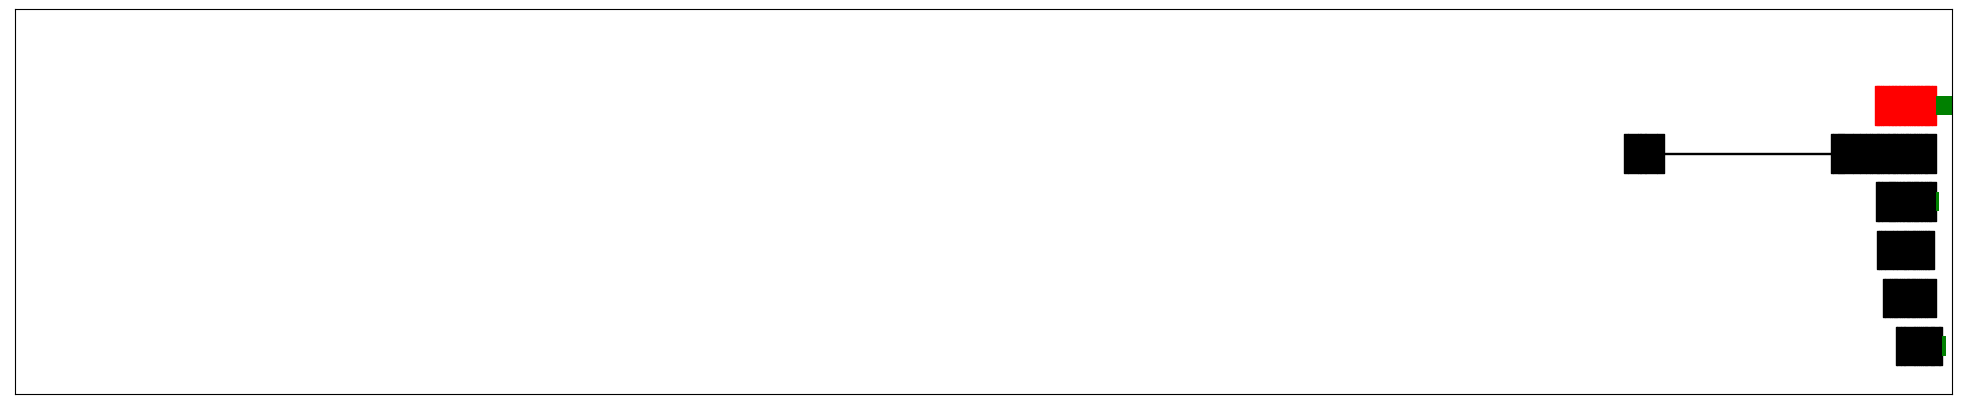

In [16]:
gene_to_plot = "zip-1"

# plot_reads(reads_df.query("lib == 'xrn-1-5tera-smg-6'"), gene_name_to_plot=gene_to_plot,
#            # t5_pos_count=1, t5_neg_count=30,
#            pad_x_axis_bounds_by=100, save_dir=f"./outputDir", save_suffix="_smg-6-KO_allReads")
plot_reads(reads_df.query("lib == 'xrn-1-5tera'"), gene_name_to_plot=gene_to_plot,
           # t5_pos_count=10, t5_neg_count=80,
           pad_x_axis_bounds_by=100, save_dir=f"./outputDir", save_suffix="_WT_allReads")